# Biostatistical analysis

# 1. Importing the modules and the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

#Utiliser edsnlp pour extraitre les 3 entités ci dessus : 
import spacy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load declared pipelines
# from edsnlp import components
from edsnlp.processing.parallel import pipe as parallel_pipe
from spacy import displacy

# For descriptive statistics
from scipy.stats import ttest_ind, chi2_contingency

# For Logistic Models implementation
from statsmodels.formula.api import logit, glm

c:\Users\gazze\anaconda3\envs\eds-tuto\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_person = pd.read_pickle('data/df_person.pkl')
df_visit = pd.read_pickle('data/df_visit.pkl')
df_condition = pd.read_pickle('data/df_condition.pkl')
df_dedup_proba = pd.read_pickle('data/df_dedup_proba.pkl')
df_note = pd.read_pickle('data/df_note.pkl')
df_bio = pd.read_pickle('data/df_bio.pkl')

In [4]:
cancer_condition = {'C50','C500','C501','C502','C503','C504'}
risk_factors = {'tabac':['Z587','Z720'], 'alcool':['T51','K70','F10'], 'diabete':['E10','E11','E12'], 'sub_psy':['Z864'], 'tum_herit':['Z803']}

# 2. Preprocessing

<a id="prepro_patient"></a>
## 2.1 Pre-processing patients' identities and demographic data

### 2.1.1 Birth dates

In [5]:
df_person.isna().sum()

birth_datetime            0
death_datetime         7320
gender_source_value       0
cdm_source                0
person_id                 0
dtype: int64

there is no missing birth_datetime.

In [6]:
#traçage de la distribution
df_person['birth_date'] = df_person['birth_datetime'].dt.strftime('%Y-%m')
birth_dates_summary = df_person.groupby("birth_date", as_index=False).person_id.count()
alt.Chart(birth_dates_summary).mark_bar(size=1).encode(
    alt.X('birth_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

This distribution looks normal !

### 2.1.2 Death dates

In [7]:
#Traçage de la distribution
df_person['death_date'] = df_person['death_datetime'].dt.strftime('%Y-%m')
death_dates_summary = df_person.groupby("death_date", as_index=False).person_id.count()
alt.Chart(death_dates_summary).mark_bar().encode(
    x='death_date:T',
    y='person_id:Q'
)

alt.Chart(...)

We do not observe any spurious data, and assume consequently that the date of death may be used with some confidence.

### 2.1.3 Gender correction

In [8]:
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['female', 'f'], 'f')
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['male', 'm'], 'm')
print(f"The available gender values are now the following : {df_person.gender_source_value.unique()}")

The available gender values are now the following : ['f' 'm']


<a id="prepro_visits"></a>
## 2.2 Pre-processing administrative data related to patients' pathways

In [9]:
df_visit['visit_start_date'] = df_visit['visit_start_datetime'].dt.strftime('%Y-%m')
visit_start_dates_summary = df_visit.groupby("visit_start_date", as_index=False).person_id.count()
alt.Chart(visit_start_dates_summary).mark_bar().encode(
    alt.X('visit_start_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

There is no problem with this distribution

<a id="prepro_cond"></a>
## 2.3 Population caracteristics

### 2.3.1 Gender distribution

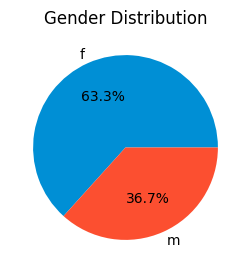

In [10]:
# Count the occurrences of each gender value
gender_counts = df_person['gender_source_value'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))  # Set the figure size
colors = ['#008fd5', '#fc4f30']  # Set colors for male and femme
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)

# Add a title
plt.title('Gender Distribution')

# Display the chart
plt.show()

### 2.3.2 Age distribution

In [11]:
df_visit_age = df_visit.merge(df_person[['person_id','birth_datetime']], on='person_id', how='inner' )
df_visit_age['age'] = (df_visit_age['visit_start_datetime'] - df_visit_age['birth_datetime'])
df_visit_age['age'] = df_visit_age['age'].dt.days // 365

visit_age_summary = df_visit_age.groupby("age", as_index=False).person_id.count()

alt.Chart(visit_age_summary).mark_bar().encode(
    x='age:T',
    y='person_id:Q'
)

alt.Chart(...)

### 2.3.3 Cancer patients

In [12]:
df_cancer = df_condition[df_condition['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer = df_cancer.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4327


# 3. Deduplication

We are going to use the probabilistic approach to do the deduplication


Plot the estimated density of the distribution of the probabilities

[]

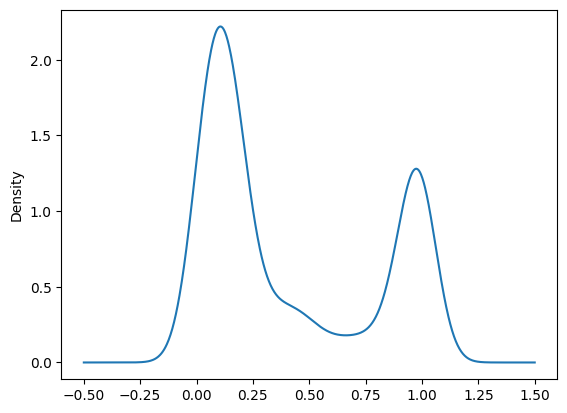

In [13]:
df_dedup_proba['prob'].plot.density()
plt.plot()

The algorithm matches correctly all the patients that were matched in the deterministic algorithm.
The peak is the result of the patient for whom we are sure the match is correct.

<a id="prepro_cond"></a>
## 3.1 Creating the function used to deduplicate the patients

Create a function `deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int)` that returns a dataset of deduplicated person ids if their similarity score was above `score`.

In [14]:
def deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int):
    #Only keep rows with a probability above the value score
    df_dedup_proba_score = df_dedup_proba[df_dedup_proba['prob'] > score]
    # Outer Join
    df_person_dedup_proba  = pd.merge(df_person, df_dedup_proba_score, on = 'person_id', how = 'outer')
    # Only unique ids in unique_person_id
    df_person_dedup_proba['unique_person_id'] = df_person_dedup_proba['unique_person_id'].fillna(df_person_dedup_proba['person_id'])
    # Only keep one row per patient
    df_person_dedup_proba = df_person_dedup_proba.drop_duplicates(['unique_person_id'], keep = 'first')
    return df_person_dedup_proba


<a id="prepro_cond"></a>
## 3.2 Determine the appropriate Score used in the probabilistic algorithm 

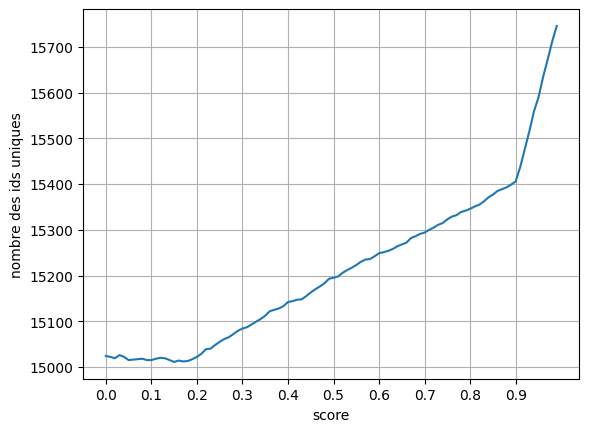

In [15]:
def nombre_id_uniques(p):
    df_person_dedup_proba_p = deduplicate_proba(df_person, df_dedup_proba, score=p)
    return df_person_dedup_proba_p.unique_person_id.nunique()
x,y=[],[]
for p in range (100):
    x.append(p/100)
    y.append(nombre_id_uniques(p/100))
    
plt.plot(x, y)
plt.xlabel('score')
plt.ylabel('nombre des ids uniques')
plt.grid(True)
plt.xticks(np.arange(0, 1, 0.1))  

plt.show()

<a id="prepro_cond"></a>
## 3.3 Deduplicating the data 

In [16]:
df_person = deduplicate_proba(df_person, df_dedup_proba, score=0.90)
print(f"We have {df_person.unique_person_id.nunique()} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.")

We have 15406 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.


In [17]:
df_condition = df_condition[df_condition.person_id.isin(df_person.person_id)]
df_visit = df_visit[df_visit.person_id.isin(df_person.person_id)]
df_note = df_note[df_note.visit_occurrence_id.isin(df_visit.visit_occurrence_id)]
df_bio = df_bio[df_bio.visit_occurrence_id.isin(df_visit.visit_occurrence_id)]

<a id="prepro_cond"></a>
## 3.4 Statistical analysis 

In [18]:
df_cancer_cond = df_condition[df_condition['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer = df_cancer_cond.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4114


In [19]:
#plotting histogram of risk factors for control and cancer population
def hist_risk_factors(dict, df_cancer_hist, df_person_hist, df_condition_hist, nbre_patients_cancer_hist):
    
    mask = df_condition_hist.apply(tuple,1).isin(df_cancer_hist.apply(tuple,1))
    df_no_cancer_hist = df_condition_hist.loc[~mask]
    nbre_patients_no_cancer = df_no_cancer_hist.person_id.nunique()
    
    #calcul des pourcentages pour les patients atteints du cancer
    id_patients_cancer=df_cancer_hist.person_id.unique()
    df_person_cancer=df_person_hist[df_person_hist['person_id'].isin(id_patients_cancer)]
    df_person_cond_cancer=df_condition_hist.merge(df_person_cancer, on='person_id', how='inner')
    l1=[]
    for factor in dict.keys():
        df=df_person_cond_cancer[df_person_cond_cancer['condition_source_value'].isin(dict[factor])]
        l1.append(df.person_id.nunique()/nbre_patients_cancer_hist*100)

    data1 ={ 'Catégorie': list(dict.keys()),
             'Pourcentage': l1}
    
    #calcul des pourcentages pour les patients non atteints du cancer
    id_patients_no_cancer=df_no_cancer_hist.person_id.unique()
    df_person_no_cancer=df_person_hist[df_person_hist['person_id'].isin(id_patients_no_cancer)]
    df_person_cond_no_cancer=df_condition_hist.merge(df_person_no_cancer, on='person_id', how='inner')
    l2=[]
    for factor in dict.keys():
        df=df_person_cond_no_cancer[df_person_cond_no_cancer['condition_source_value'].isin(dict[factor])]
        l2.append(df.person_id.nunique()/nbre_patients_no_cancer*100)

    data2 ={ 'Catégorie': list(dict.keys()),
             'Pourcentage': l2}
    
    categories = data1['Catégorie']
    pourcentages1 = data1['Pourcentage']
    pourcentages2 = data2['Pourcentage']

    X_axis = np.arange(len(categories))
    plt.bar(X_axis - 0.2 , pourcentages1, 0.4, label='cancer')
    plt.bar(X_axis + 0.2 , pourcentages2, 0.4, label='controle')
    plt.xticks(X_axis, categories)
    plt.xlabel('Catégorie')
    plt.ylabel('Pourcentage')
    plt.title('Histogramme des facteurs de risque')
    plt.legend()
    plt.show()

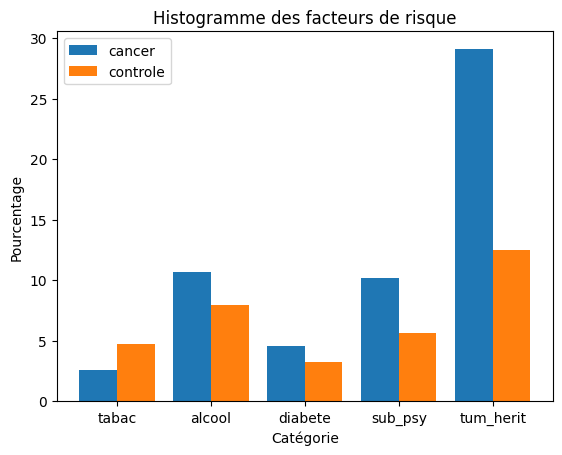

In [20]:
hist_risk_factors(risk_factors, df_cancer, df_person, df_condition, nbre_patients_cancer)

# 4. NLP-algorithm

<a id="prepro_cond"></a>
## 4.1 Defining the terms 

In [21]:
# Clinicians indicated that the following synonyms could be used

terms = dict(
   tabac=['tabac','fumeur','tabagisme','nicotine','cigarette','cigarettes','fume','fumer','fumait','tabagique','fumeuse','fumé'],
   alcool=['alcool','alcoolisme','Alcoolodépendance','Alcoolodépendant','Alcoolisation','alcoolique'],
   diabete=['Diabète','Hyperglycémie','Hypoglycémie','Diabétique','Polyurie','Polydipsie','Polyphagie','diabète','hyperglycémie','hypoglycémie','diabétique','polyurie','polydipsie','polyphagie'],
   sub_psy=['Psychoactive','Psychotrope','Psychostimulant','Psychodysleptique','Psychodélirant','Narcotique','Sédatif','Hypnotique','Anxiolytique','Antidépresseur','Stimulant','Hallucinogène','Dépresseur','Opiacé','Cannabinoïde','Dissociatif','Inhalant','psychoactive','psychotrope','psychostimulant','psychodysleptique','psychodélirant','narcotique','sédatif','hypnotique','anxiolytique','antidépresseur','stimulant','hallucinogène','dépresseur','opiacé','cannabinoïde','dissociatif','inhalant'],
   tum_herit=['antécédents familiaux de tumeur maligne du sein']
)

<a id="prepro_cond"></a>
## 4.2 Defining the necessary functions

In [22]:
def pick_results(doc):
    """
    This function provides the entities that must be collected by the nlp process.
    """
    return [{
             'note_id':e.doc._.note_id,
             'visit_occurrence_id':e.doc._.visit_occurrence_id,
             'lexical_variant':e.text,
             'label':e.label_,
             'negation':e._.negation
             } 
             for e in doc.ents if doc.ents]

In [23]:
def calc_value(x):
    state = {'tabac':'unknown', 'alcool':'unknown', 'diabete':'unknown', 'sub_psy':'unknown', 'tum_herit':'unknown', }
    for _, row in x.iterrows():
        for factor in state.keys():
            if row['label'] == factor and row['negation']:
                if state[factor] == "unknown" :
                    state[factor] = "False"
                elif state[factor] == "True" :
                    state[factor] = "ambiguous"
            if row['label'] == factor and not(row['negation']):
                if state[factor] == "unknown" :
                    state[factor] = "True"
                elif state[factor] == "False" :
                    state[factor] = "ambiguous"
    return state

<a id="prepro_cond"></a>
## 4.3 Applying the NLP-algorithm

In [24]:
nlp = spacy.blank("fr")
# sentencizer component
nlp.add_pipe('eds.sentences')
nlp.add_pipe("eds.normalizer")
# Matcher component
nlp.add_pipe("eds.matcher", config=dict(terms=terms))
nlp.add_pipe("eds.negation")

In [25]:
ents = parallel_pipe(
                df_note,
                nlp,
                context=['note_id', 'visit_occurrence_id'],
                progress_bar=False,
                n_jobs=1, 
                results_extractor = pick_results,
                )

In [26]:
ents_grouped = ents.groupby('visit_occurrence_id').apply(calc_value).to_frame('state').reset_index()    
for factor in risk_factors :
    ents_grouped[factor] = ents_grouped.state.apply(lambda x : x[factor]=='True')
ents_grouped = ents_grouped.drop(columns=['state'])
ents_grouped.head()

,visit_occurrence_id,tabac,alcool,diabete,sub_psy,tum_herit
0,80001324.0,True,False,False,False,False
1,80001693.0,True,False,False,False,False
2,80002464.0,False,False,False,False,False
3,80002814.0,False,False,False,False,False
4,80002980.0,True,False,False,False,False


<a id="prepro_cond"></a>
## 4.4 Evaluating the performance of the nlp-algorithm

On a vérifié à la main les résultats fournis par notre algorithme de détection du tabagisme pour 50 patients afin de vérifier sa perfomrance

On a calculé les vrais positifs, vrais négatifs, faux positifs et faux négatifs

In [45]:
VP = 20
VN = 17
FP = 3
FN = 10
print('sensitivity = ', round(VP/(VP+FN),2), '\nspecificity = ', round(VN/(VN+FP),2))  

sensitivity =  0.67 
specificity =  0.85


# 5. Biostatical Analysis

<a id="prepro_cond"></a>
## 5.1 Merging the data from the NLP-algorithm and the df_condition

In [27]:
code_to_risk_factor = {}
for key,code_list in risk_factors.items() :
    for code in code_list :
        code_to_risk_factor[code] = key

In [28]:
#extracting the data about the risk factors from df_condition
df_condition["risk_factor"] = df_condition.condition_source_value.map(code_to_risk_factor)
df_risk_factors = df_condition[df_condition.risk_factor.notna()].drop(columns=['condition_occurrence_id','condition_source_value'])
df_risk_factors['value'] = True
df_risk_factors = df_risk_factors.pivot(index='visit_occurrence_id', columns=['risk_factor'], values='value').reset_index()
df_risk_factors = df_risk_factors.fillna(False)
df_risk_factors.head()

risk_factor,visit_occurrence_id,alcool,diabete,sub_psy,tabac,tum_herit
0,80001693.0,True,False,False,False,False
1,80003678.0,False,False,True,False,False
2,80007123.0,True,False,False,False,False
3,80008076.0,True,False,False,False,True
4,80008149.0,True,True,False,False,True


In [29]:
#merging the two dataframes(from the df_condition and the nlp-algorithm)
df_risk_factors = df_risk_factors.merge(ents_grouped, on='visit_occurrence_id', how='outer').fillna(False)
df_risk_factors

,visit_occurrence_id,alcool_x,diabete_x,sub_psy_x,tabac_x,tum_herit_x,tabac_y,alcool_y,diabete_y,sub_psy_y,tum_herit_y
0,80001693.0,True,False,False,False,False,True,False,False,False,False
1,80003678.0,False,False,True,False,False,True,False,False,False,False
2,80007123.0,True,False,False,False,False,False,False,False,False,False
3,80008076.0,True,False,False,False,True,False,False,False,False,False
4,80008149.0,True,True,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
15360,89998804.0,False,False,False,False,False,True,False,False,False,False
15361,89999192.0,False,False,False,False,False,False,False,False,False,False
15362,89999415.0,False,False,False,False,False,True,False,False,False,False
15363,89999467.0,False,False,False,False,False,True,True,False,False,False


In [30]:
df_risk_factors['tabac'] = df_risk_factors.tabac_x | df_risk_factors.tabac_y
df_risk_factors['alcool'] = df_risk_factors.alcool_x | df_risk_factors.alcool_y
df_risk_factors['diabete'] = df_risk_factors.diabete_x | df_risk_factors.diabete_y
df_risk_factors['sub_psy'] = df_risk_factors.sub_psy_x | df_risk_factors.sub_psy_y
df_risk_factors['tum_herit'] = df_risk_factors.tum_herit_x | df_risk_factors.tum_herit_y

df_risk_factors = df_risk_factors.drop(columns=['tabac_x','alcool_x','diabete_x','sub_psy_x','tum_herit_x','tabac_y','alcool_y','diabete_y','sub_psy_y','tum_herit_y'])
df_risk_factors.head()

,visit_occurrence_id,tabac,alcool,diabete,sub_psy,tum_herit
0,80001693.0,True,True,False,False,False
1,80003678.0,True,False,False,True,False
2,80007123.0,False,True,False,False,False
3,80008076.0,False,True,False,False,True
4,80008149.0,True,True,True,False,True


<a id="prepro_cond"></a>
## 5.2 Adding the personal data of the patients to the risk_factors

In [31]:
data = df_person[["person_id", "birth_datetime", "gender_source_value"]]
data = pd.merge(data, df_visit[["person_id", "visit_occurrence_id" ,"visit_start_datetime"]], on="person_id", how="inner")
data['age'] = round(((data['visit_start_datetime'] - data['birth_datetime']).dt.days/ 365), 2)
data["male"] = data.gender_source_value == "m"
data.head()

,person_id,birth_datetime,gender_source_value,visit_occurrence_id,visit_start_datetime,age,male
0,86484326,2016-08-02,f,88518653.0,2024-06-14,7.87,False
1,89213495,2013-11-01,f,87739827.0,2022-01-22,8.23,False
2,88207887,2013-04-02,f,83376027.0,2022-02-15,8.88,False
3,80499395,2016-08-19,f,86253160.0,2021-09-19,5.09,False
4,84190053,2022-06-04,f,89174506.0,2022-10-30,0.41,False


In [32]:
data = pd.merge(data, df_risk_factors, on="visit_occurrence_id", how="left").fillna({"tabac":False, 'alcool':False, "diabete":False, 'sub_psy':False, 'tum_herit':False})
data = data.drop(columns=['birth_datetime','gender_source_value','visit_start_datetime'])
data.head()

,person_id,visit_occurrence_id,age,male,tabac,alcool,diabete,sub_psy,tum_herit
0,86484326,88518653.0,7.87,False,False,False,False,False,False
1,89213495,87739827.0,8.23,False,True,True,False,False,False
2,88207887,83376027.0,8.88,False,False,False,False,False,False
3,80499395,86253160.0,5.09,False,False,False,False,False,False
4,84190053,89174506.0,0.41,False,False,False,False,False,False


<a id="prepro_cond"></a>
## 5.2 Adding the biological measurements

In [33]:
df_bio.concept_source_value.value_counts()

bmi     15406
hb      15406
urea    15406
crp     15406
Name: concept_source_value, dtype: int64

In [34]:
bio_processed = df_bio[["visit_occurrence_id", "concept_source_value", "transformed_value"]].pivot(index=["visit_occurrence_id"], columns="concept_source_value", values="transformed_value").reset_index()
bio_processed.head()

concept_source_value,visit_occurrence_id,bmi,crp,hb,urea
0,80001324.0,19.42,4.58,13.16,5.39
1,80001693.0,24.77,4.78,9.63,4.45
2,80002464.0,21.84,4.02,15.67,4.86
3,80002814.0,23.12,4.42,17.55,2.57
4,80002980.0,22.39,4.48,9.81,2.74


In [35]:
data = pd.merge(data, bio_processed, on="visit_occurrence_id", how="left")
data = data.drop(columns='visit_occurrence_id')
data.head()

,person_id,age,male,tabac,alcool,diabete,sub_psy,tum_herit,bmi,crp,hb,urea
0,86484326,7.87,False,False,False,False,False,False,16.87,4.32,8.69,2.75
1,89213495,8.23,False,True,True,False,False,False,20.04,5.18,12.47,2.69
2,88207887,8.88,False,False,False,False,False,False,20.58,4.85,13.47,2.83
3,80499395,5.09,False,False,False,False,False,False,17.68,5.23,13.75,2.57
4,84190053,0.41,False,False,False,False,False,False,19.21,4.29,11.99,3.15


In [36]:
#adding the cancer status of every patient
data['cancer'] = data.person_id.isin(df_cancer_cond.person_id)
data.head()

,person_id,age,male,tabac,alcool,diabete,sub_psy,tum_herit,bmi,crp,hb,urea,cancer
0,86484326,7.87,False,False,False,False,False,False,16.87,4.32,8.69,2.75,False
1,89213495,8.23,False,True,True,False,False,False,20.04,5.18,12.47,2.69,False
2,88207887,8.88,False,False,False,False,False,False,20.58,4.85,13.47,2.83,False
3,80499395,5.09,False,False,False,False,False,False,17.68,5.23,13.75,2.57,False
4,84190053,0.41,False,False,False,False,False,False,19.21,4.29,11.99,3.15,False


In [37]:
data.isna().sum(axis=0)

person_id    0
age          0
male         0
tabac        0
alcool       0
diabete      0
sub_psy      0
tum_herit    0
bmi          0
crp          0
hb           0
urea         0
cancer       0
dtype: int64

<a id="prepro_cond"></a>
## 5. Statistical analysis

In [38]:
#defining our two populations
df_control = data[data['cancer'] == False]
df_cancer = data[data['cancer']]

In [39]:
#defining functions for statistical measurements
def prevalence(values):
    return round(values.sum()*100 / len(values),2)

def mean_sd(values):
    return (round(values.mean(), 2), round(values.std(), 2))

In [40]:
agg_dict = {
    "person_id": ["count"],
    "age": [mean_sd],
    "male": [prevalence],
    "tabac" : [prevalence],
    "alcool" : [prevalence],
    "diabete" : [prevalence],
    "sub_psy" : [prevalence],
    "tum_herit" : [prevalence],
    "bmi" : [mean_sd],
    "crp": [mean_sd],
    "hb": [mean_sd],
    "urea": [mean_sd],
}

numerical = ["age", "bmi", "crp", "hb", "urea"]
test_categorical = ["male", "diabete", "tabac", 'alcool', 'sub_psy', 'tum_herit']

In [41]:
data_summary = data.groupby("cancer").agg(agg_dict).T
data_summary

,cancer,False,True
person_id,count,11292,4114
age,mean_sd,"(50.59, 27.54)","(78.52, 14.0)"
male,prevalence,50.26,0.0
tabac,prevalence,49.51,58.24
alcool,prevalence,7.86,14.88
diabete,prevalence,2.34,4.55
sub_psy,prevalence,3.36,10.18
tum_herit,prevalence,4.95,29.1
bmi,mean_sd,"(21.37, 3.19)","(24.98, 1.99)"
crp,mean_sd,"(4.54, 0.32)","(4.51, 0.3)"


In [42]:
#calculating the p_values
for feat, sub_value in data_summary.index:
    if feat in numerical:
        data_summary.loc[(feat,sub_value),"t-test *e10"] = round(ttest_ind(df_control[feat], df_cancer[feat])[1],11) * 10**10

    if feat in test_categorical:
        data_summary.loc[(feat,sub_value),"chi-sq *e10"] = round(chi2_contingency(pd.crosstab(data["cancer"], data[feat]))[1],11) * 10**10

In [43]:
data_summary['p_value *e10'] = data_summary['t-test *e10'].fillna(data_summary['chi-sq *e10'])
data_summary['p_value *e10'] = data_summary['p_value *e10'].fillna('')
data_summary = data_summary.rename(columns = {False : 'Cohorte Control', True : 'Cohorte avec Cancer'})
data_summary = data_summary[['Cohorte Control', 'Cohorte avec Cancer', 'p_value *e10']]

In [44]:
data_summary

,cancer,Cohorte Control,Cohorte avec Cancer,p_value *e10
person_id,count,11292,4114,
age,mean_sd,"(50.59, 27.54)","(78.52, 14.0)",0.0
male,prevalence,50.26,0.0,0.0
tabac,prevalence,49.51,58.24,0.0
alcool,prevalence,7.86,14.88,0.0
diabete,prevalence,2.34,4.55,0.0
sub_psy,prevalence,3.36,10.18,0.0
tum_herit,prevalence,4.95,29.1,0.0
bmi,mean_sd,"(21.37, 3.19)","(24.98, 1.99)",0.0
crp,mean_sd,"(4.54, 0.32)","(4.51, 0.3)",8.2
